In [194]:
# Imports
import os
import numpy as np
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Activation, Flatten, MaxPooling2D, SeparableConv2D, UpSampling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

img_rows, img_cols = 64, 64
train_data_dir = './dataset/train'
validation_data_dir = './dataset/validation'

In [195]:
IMG_SHAPE = img_cols, img_rows, 3
classes = 2

In [196]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

datagen = ImageDataGenerator(rescale=1./255)

#automatically retrive images and their classes for training and validation
train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [197]:
num_train_samples = train_generator.samples
num_validation_samples = validation_generator.samples

print('num_train_samples: ' + str(num_train_samples))
print('num_validation_samples: ' + str(num_validation_samples))

num_train_samples: 8000
num_validation_samples: 2000


In [198]:
def entry_flow(inputs):

    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    previous_block_activation = x

    for size in [128, 256, 728]:

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        residual = Conv2D(size, 1, strides=2, padding='same')(
            previous_block_activation)

        x = tensorflow.keras.layers.Add()([x, residual])
        previous_block_activation = x

    return x


In [199]:
def middle_flow(x, num_blocks=8) :

    previous_block_activation = x

    for _ in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        # x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        # x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        # x = BatchNormalization()(x)

        x = tensorflow.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x

    return x

In [200]:
def exit_flow(x) :

    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    #x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x) 
    #x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = tensorflow.keras.layers.Add()([x, residual])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    #x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    #x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)

    return x

In [201]:
inputs = Input(shape=(img_rows, img_cols, 3))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = Model(inputs, outputs)

In [202]:
xception.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 32, 32, 32)   896         input_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_364 (BatchN (None, 32, 32, 32)   128         conv2d_82[0][0]                  
__________________________________________________________________________________________________
activation_454 (Activation)     (None, 32, 32, 32)   0           batch_normalization_364[0][0]    
___________________________________________________________________________________________

In [203]:
opt = tensorflow.keras.optimizers.Adam()
xception.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [204]:
history_1= xception.fit_generator(train_generator,
                    steps_per_epoch=num_train_samples // batch_size,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=num_validation_samples // batch_size)

Epoch 1/30


/home/nsssayom/.local/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


125/125 [==============================] - 33s 234ms/step - loss: 0.0749 - accuracy: 0.9660 - val_loss: 2.4934 - val_accuracy: 0.4960
Epoch 2/30
125/125 [==============================] - 29s 229ms/step - loss: 0.0117 - accuracy: 0.9959 - val_loss: 3.6344 - val_accuracy: 0.4960
Epoch 3/30
125/125 [==============================] - 28s 225ms/step - loss: 0.0082 - accuracy: 0.9980 - val_loss: 4.5399 - val_accuracy: 0.4960
Epoch 4/30
125/125 [==============================] - 28s 225ms/step - loss: 0.0094 - accuracy: 0.9967 - val_loss: 0.5129 - val_accuracy: 0.8226
Epoch 5/30
125/125 [==============================] - 28s 226ms/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.0871 - val_accuracy: 0.9808
Epoch 6/30
125/125 [==============================] - 29s 228ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0522 - val_accuracy: 0.9899
Epoch 7/30
125/125 [==============================] - 28s 221ms/step - loss: 0.0137 - accuracy: 0.9964 - val_loss: 0.0203 - val_accuracy: 0.9

In [205]:
import seaborn as sns

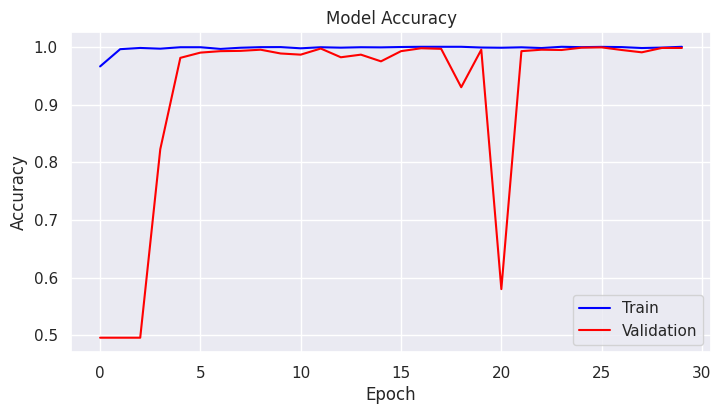

In [206]:
#  "Accuracy"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['accuracy'], color="blue")
plt.plot(history_1.history['val_accuracy'] , color="red")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig('./graph/TwoClass_accuracy_raw_1.svg')


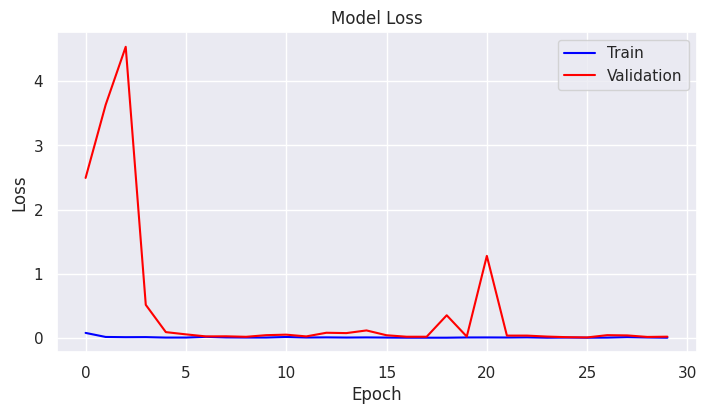

In [207]:
# "Loss"
plt.figure(figsize=[8, 4])
sns.set_theme()
plt.plot(history_1.history['loss'], color="blue")
plt.plot(history_1.history['val_loss'], color="red")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
plt.savefig('./graph/TwoClass_loss_raw_1.svg')
#plt.savefig('G:/Nazia/BanglaLekha/Comp-graph/Com_loss18.png')

In [208]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [209]:
batch_size=64

In [220]:
Y_pred = xception.predict_generator(validation_generator, num_validation_samples// batch_size+1)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
y_true= validation_generator.classes

target_names = ['Cracked', 'Non-Cracked']
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

/home/nsssayom/.local/lib/python3.9/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


(2000, 2)
              precision    recall  f1-score   support

     Cracked      1.000     0.996     0.998      1000
 Non-Cracked      0.996     1.000     0.998      1000

    accuracy                          0.998      2000
   macro avg      0.998     0.998     0.998      2000
weighted avg      0.998     0.998     0.998      2000



In [211]:
cm = confusion_matrix(y_true, y_pred)

In [212]:
classes=2

In [213]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1]), ):
        plt.text(j, i, cm[i, j, ],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

In [214]:
import imp
imp.reload(sns)

<module 'seaborn' from '/home/nsssayom/.local/lib/python3.9/site-packages/seaborn/__init__.py'>

In [215]:
sns.reset_defaults()

In [216]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties

# plt.figure() 
# prop = FontProperties()
# prop.set_file('Siyamrupali.ttf')

Confusion matrix, without normalization
[[ 996    4]
 [   0 1000]]


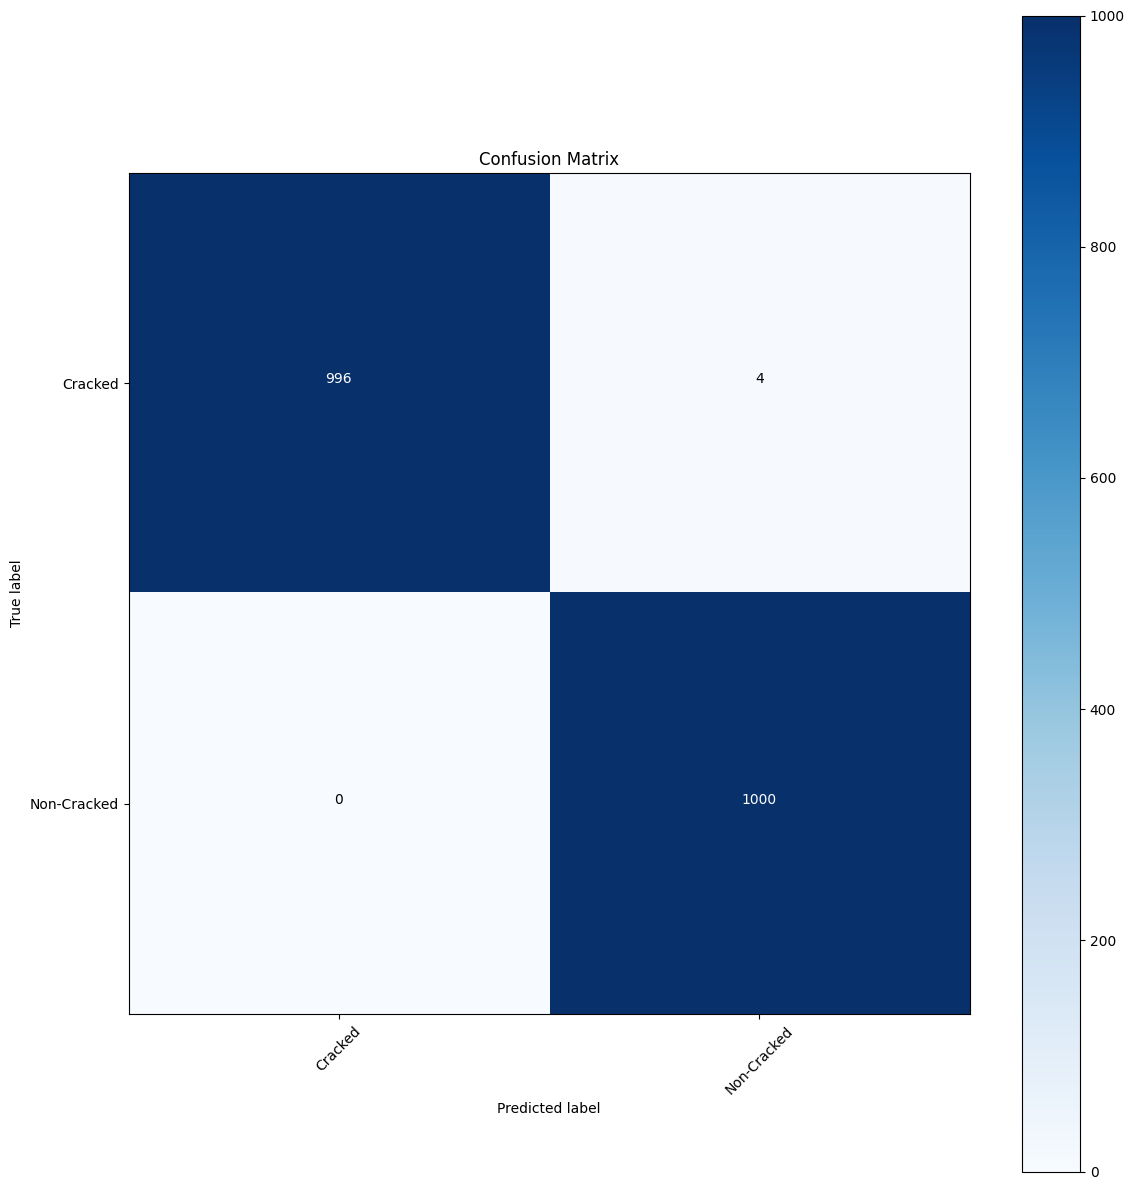

In [217]:
cm_plot_labels = ['Cracked', 'Non-Cracked']
#sns.set_theme()
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')
plt.savefig('./graph/TwoClass_conf_Raw_1.svg')
#plt.savefig('G:/Nazia/BanglaLekha/Comp-graph/cf_val_git_05.png')